# Problem Statement

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.

Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales.

Dataset : https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

In [2]:
train = pd.read_csv("D:\CHIRAG\Analytics Vidhya Hackathon\Big Mart Sales\Train_UWu5bXk.csv")
train['common'] = 'train'
test = pd.read_csv("D:\CHIRAG\Analytics Vidhya Hackathon\Big Mart Sales\Test_u94Q5KV.csv")
test['common'] = 'test'
data = pd.concat([train, test], ignore_index = True)
data.head()

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,common
0,Low Fat,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,Tier 1,Medium,Supermarket Type1,train
1,Regular,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,Tier 3,Medium,Supermarket Type2,train
2,Low Fat,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,OUT049,Tier 1,Medium,Supermarket Type1,train
3,Regular,FDX07,182.0950,732.3800,Fruits and Vegetables,0.000000,19.20,1998,OUT010,Tier 3,NaN,Grocery Store,train
4,Low Fat,NCD19,53.8614,994.7052,Household,0.000000,8.93,1987,OUT013,Tier 3,High,Supermarket Type1,train


In [3]:
data.columns

Index(['Item_Fat_Content', 'Item_Identifier', 'Item_MRP', 'Item_Outlet_Sales',
       'Item_Type', 'Item_Visibility', 'Item_Weight',
       'Outlet_Establishment_Year', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Type', 'common'],
      dtype='object')

In [4]:
data.describe()

,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year
count,14204.000000,8523.000000,14204.000000,11765.000000,14204.000000
mean,141.004977,2181.288914,0.065953,12.792854,1997.830681
std,62.086938,1706.499616,0.051459,4.652502,8.371664
min,31.290000,33.290000,0.000000,4.555000,1985.000000
25%,94.012000,834.247400,0.027036,8.710000,1987.000000
50%,142.247000,1794.331000,0.054021,12.600000,1999.000000
75%,185.855600,3101.296400,0.094037,16.750000,2004.000000
max,266.888400,13086.964800,0.328391,21.350000,2009.000000


Note: Here item visibility has minimum value of 0. Now that's not possible. So it needs to be corrected. Lets look further into the data

In [5]:
data.apply(lambda x: len(x.unique()))

Item_Fat_Content                 5
Item_Identifier               1559
Item_MRP                      8052
Item_Outlet_Sales             3494
Item_Type                       16
Item_Visibility              13006
Item_Weight                    416
Outlet_Establishment_Year        9
Outlet_Identifier               10
Outlet_Location_Type             3
Outlet_Size                      4
Outlet_Type                      4
common                           2
dtype: int64

We will try to reduce the number of unique values in variables where it is possible.

## Data Cleaning

In [6]:
#Correct Item_Fat_Content variable
print(data.Item_Fat_Content.unique())
#data.Item_Fat_Content = data.Item_Fat_Content.str.upper()
data.Item_Fat_Content = data.Item_Fat_Content.replace({'low fat' : 'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular'})
print(data.Item_Fat_Content.unique())

['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
['Low Fat' 'Regular']


### Handling missing data

In [7]:
data.isnull().sum()

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                  2439
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                  4016
Outlet_Type                     0
common                          0
dtype: int64

###### Item_Weight

In [8]:
#Determine the average weight per item:
item_avg_weight = data.pivot_table(values = 'Item_Weight', index = 'Item_Identifier', aggfunc = 'mean')
#Fill missing item_weight values of each item with the item's average weight (based om Item_Identifier)
miss_bool = data.Item_Weight.isnull()
data.loc[miss_bool, 'Item_Weight'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: item_avg_weight[item_avg_weight.index == x].Item_Weight.values[0])
print("Item_Weight missing values =", data.Item_Weight.isnull().sum()) 

Item_Weight missing values = 0


###### Outlet_Size

In [9]:
data.Outlet_Type.unique()

array(['Supermarket Type1', 'Supermarket Type2', 'Grocery Store',
       'Supermarket Type3'], dtype=object)

In [10]:
#Only Supermarket type1 and grocery store contain nan values.
for i in data.Outlet_Type.unique():
    print(i,':', data.loc[data.Outlet_Type == i].Outlet_Size.unique())
print()
#Further looking at Supermarket type1, it is found that location with type tier 2 has small and missing values
print(((data.loc[data.Outlet_Type == 'Supermarket Type1']).loc[data.Outlet_Location_Type == 'Tier 2']).Outlet_Size.unique())

Supermarket Type1 : ['Medium' 'High' nan 'Small']
Supermarket Type2 : ['Medium']
Grocery Store : [nan 'Small']
Supermarket Type3 : ['Medium']

[nan 'Small']


In [11]:
#So, replace missing values by Small in both grocery store as well as in Supermarket type1 with tier 2
data.Outlet_Size = data.Outlet_Size.fillna('Small')
print("Outlet_Size missing values =", data.Outlet_Size.isnull().sum())

Outlet_Size missing values = 0


###### Item_Visibility
Item_Visibility has 879 0 values which is practically not possible. So replace thode zero values.

In [12]:
#First try to put average values of product visibilty based on item identifier and outlet type
print("Initial total number of Item_Visibilty=0 is =", sum(data.Item_Visibility == 0))

#First replace 0 values with nan values because they will lower the mean visibility of product
data['Item_Visibility'] = np.where(data.Item_Visibility == 0, np.nan, data.Item_Visibility)
#Determine average visibility of a product
visibility_avg = data.pivot_table(values='Item_Visibility', index=['Item_Identifier', 'Outlet_Type'])

#Impute nan values with mean visibility of that product based on item identifier and outlet type:
miss_bool = data.Item_Visibility.isnull()
data.loc[miss_bool, "Item_Visibility"] = data.loc[miss_bool, ['Item_Identifier', 'Outlet_Type']].apply(lambda x: visibility_avg.loc[(visibility_avg.index.get_level_values('Item_Identifier') == x.Item_Identifier) & (visibility_avg.index.get_level_values('Outlet_Type') == x.Outlet_Type)].Item_Visibility.values[0], axis = 1)
print("Now total number of Item_Visibilty with nan values =", sum(data.Item_Visibility.isnull()))

Initial total number of Item_Visibilty=0 is = 879
Now total number of Item_Visibilty with nan values = 239


Still 239 are with nan values. So now, replace them with average values of  product visibility based on only item identifier

In [13]:
#Determine average visibility of a product
visibility_avg = data.pivot_table(values='Item_Visibility', index=['Item_Identifier'])

#Impute nan values with mean visibility of that product:
miss_bool = data.Item_Visibility.isnull()
data.loc[miss_bool,'Item_Visibility'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: visibility_avg[visibility_avg.index == x].Item_Visibility.values[0])
print("Final total number of Item_Visibilty with nan values =", sum(data.Item_Visibility.isnull()))

Final total number of Item_Visibilty with nan values = 0


This completes our data cleaning part.

## Feature Engineering

###### Item_Visibility_MeanRatio

One feature can be generated by comparing how much importance in visibility is given to a product in a store as compared to other stores.

In [14]:
#Determine another variable with means ratio
data['Item_Visibility_MeanRatio'] = data.apply(lambda x: x['Item_Visibility']/visibility_avg[visibility_avg.index == x['Item_Identifier']].values[0], axis = 1).Item_Visibility
data['Item_Visibility_MeanRatio'].describe()

count    14204.000000
mean         1.000000
std          0.204894
min          0.844424
25%          0.878673
50%          0.926047
75%          0.999070
max          1.615921
Name: Item_Visibility_MeanRatio, dtype: float64

###### Outlet_Experience

Let's generate a new feature that gives the years of experience of a store

In [16]:
data['Outlet_Experience'] = (2013 - data['Outlet_Establishment_Year'])
data.Outlet_Experience.describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Experience, dtype: float64

###### Item_Type_Combined

Item_Type variable has 16 variables. But, we can classify them into 3 categories with the help of unique ID's.

In [15]:
#Get the first two characters of ID:
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])
#Rename them to more intuitive categories:
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food', 'NC':'Non-Consumable', 'DR':'Drinks'})
data['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

Now, one thing to note is we have Item_Fat_Content variable as regular or low fat. But we generated a new variable Item_Type_Combined as food, drinks and non-consumable. This suggests that non-consumable food shouldn't have fat content. So, seperate them and name them as non-edible.

In [17]:
data.loc[data.Item_Type_Combined == 'Non-Consumable', 'Item_Fat_Content'] = 'Non-Edible'
data.Item_Fat_Content.value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

### Handling Categorical Variables

Now, one main step is to handle categorical variables in python. We will now convert all variables into numerical type.

In [18]:
#Filter categorical variables
categorical_columns = [x for x in data.dtypes.index if data.dtypes[x] == 'object']
categorical_columns = [x for x in categorical_columns if x not in ['Item_Identifier', 'Outlet_Identifier', 'common']]
#Print frequency of categories
for i in categorical_columns:
    print("Frequency of categories for variable %s" %i)
    print(data[i].value_counts())
    print()

Frequency of categories for variable Item_Fat_Content
Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

Frequency of categories for variable Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Frequency of categories for variable Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

Frequency of categories for variable Outlet_Size
Small     7996
Medium    4655
High      1553
Name: Outlet_Size, dtype: int64

Frequency of categori

Note: Here we have all categorical variables with more than 2 types. Thus we will use one-hot encoding(get_dummies, LabelBinarizer, OneHotEncoder) instead of lable encoding as it has a disadvantage that the numerical values can be misinterpreted by the algorithm.

But first apply label encoding to the Item_Identifier as we could not apply get_dummies to it as original Item_Identifier will be required in the test dataset.

In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])

In [20]:
data = pd.get_dummies(data, columns = ['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Type', 'Item_Type_Combined', 'Outlet'])
data.head()

,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,common,Item_Visibility_MeanRatio,Outlet_Experience,...,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
0,FDA15,249.8092,3735.1380,0.016047,9.30,1999,OUT049,train,0.931078,14,...,0,0,0,0,0,0,0,0,0,1
1,DRC01,48.2692,443.4228,0.019278,5.92,2009,OUT018,train,0.933420,4,...,0,0,0,1,0,0,0,0,0,0
2,FDN15,141.6180,2097.2700,0.016760,17.50,1999,OUT049,train,0.875963,14,...,0,0,0,0,0,0,0,0,0,1
3,FDX07,182.0950,732.3800,0.022930,19.20,1998,OUT010,train,1.000000,15,...,1,0,0,0,0,0,0,0,0,0
4,NCD19,53.8614,994.7052,0.013203,8.93,1987,OUT013,train,0.931066,26,...,0,1,0,0,0,0,0,0,0,0


Note here I have used both Item_Type as well as Item_Type_Combined as to see if it makes any importance in the model

In [21]:
data.dtypes

Item_Identifier                       object
Item_MRP                             float64
Item_Outlet_Sales                    float64
Item_Visibility                      float64
Item_Weight                          float64
Outlet_Establishment_Year              int64
Outlet_Identifier                     object
common                                object
Item_Visibility_MeanRatio            float64
Outlet_Experience                      int64
Item_Fat_Content_Low Fat               uint8
Item_Fat_Content_Non-Edible            uint8
Item_Fat_Content_Regular               uint8
Item_Type_Baking Goods                 uint8
Item_Type_Breads                       uint8
Item_Type_Breakfast                    uint8
Item_Type_Canned                       uint8
Item_Type_Dairy                        uint8
Item_Type_Frozen Foods                 uint8
Item_Type_Fruits and Vegetables        uint8
Item_Type_Hard Drinks                  uint8
Item_Type_Health and Hygiene           uint8
Item_Type_

## Spliting data into train and test set

In [22]:
pd.options.mode.chained_assignment = None #for handling warning

train = data.loc[data.common == "train"]
train.drop(['common'], axis = 1, inplace = True)

test = data.loc[data.common == "test"]
test.drop(['Item_Outlet_Sales', 'common'], axis = 1, inplace = True)

## Model Building

In [52]:
X_train = train.drop(['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales'], axis = 1)
y_train = train['Item_Outlet_Sales']
X_test = test.drop(['Item_Identifier', 'Outlet_Identifier'], axis = 1)

In [24]:
from sklearn.metrics import mean_squared_error

In [25]:
#For trees only
def model(clf):
    model = clf.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    #Root mean square error
    print("RMSE :", np.sqrt(mean_squared_error(y_train.values, clf.predict(X_train))))
    #Cross Validation
    cv_score = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    print("Mean CV_Score",np.mean(cv_score))
    #Plot feature importance
    clf_feature = clf.fit(X_train, y_train).feature_importances_
    feature = pd.Series(clf_feature, X_train.columns).sort_values(ascending = False)
    plt.figure(figsize = (15,6))
    feature.plot(kind = 'bar', title = 'Feature Importance')
    return test[['Item_Identifier', 'Outlet_Identifier']].reset_index().assign(Item_Outlet_Sales = pd.Series(y_pred)).drop('index', axis = 1)

### Random Forest

RMSE : 488.57726800275566
Mean CV_Score 1179.70249937536


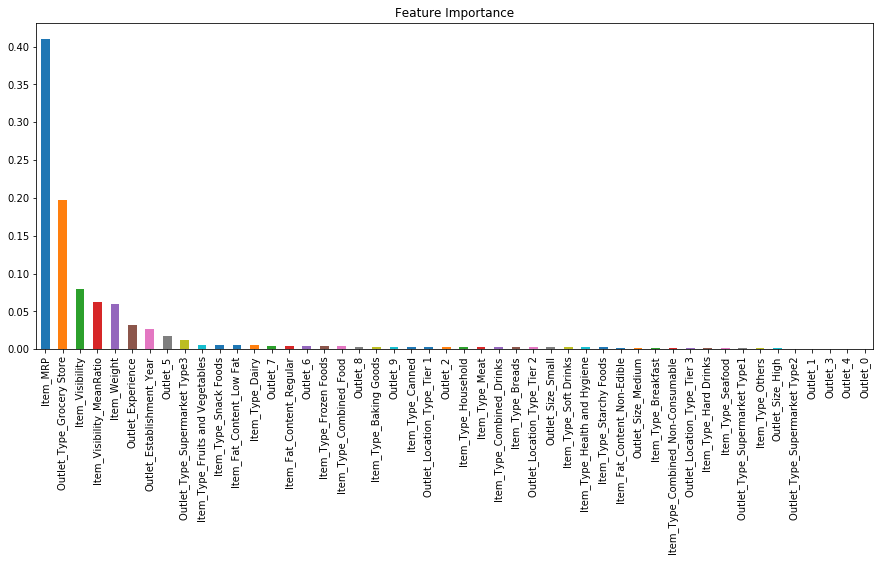

In [26]:
from sklearn.ensemble import RandomForestRegressor #Not Classifier as target variables contains float values (i.e., continous)
rfr = RandomForestRegressor(random_state = 0)
RFR = model(rfr)
#RFR.to_csv('RFR.csv', index = None)

### XGBoost

In [28]:
from xgboost import XGBRegressor

RMSE : 1035.5058269087988
Mean CV_Score 1083.519940596179


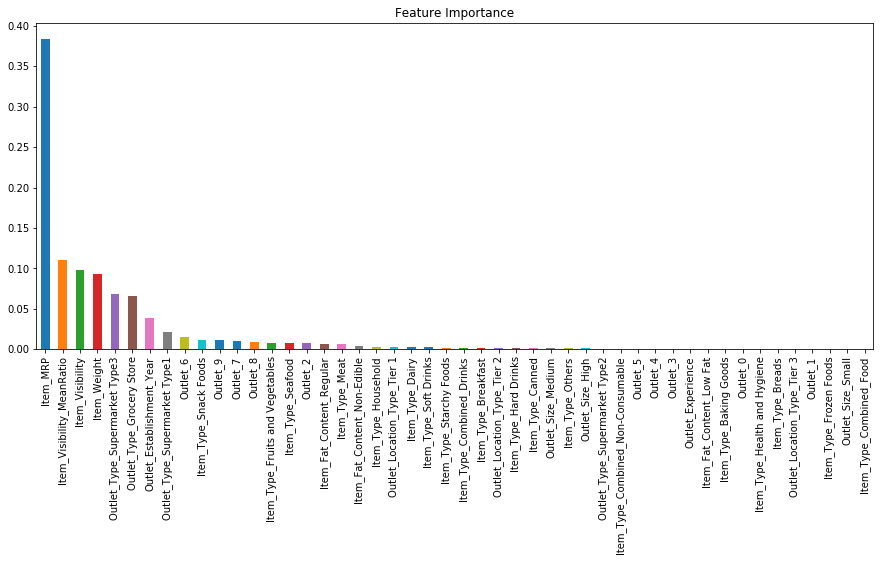

In [30]:
clf = XGBRegressor(random_state = 0)
XGBR = model(clf)
#XGBR.to_csv('XGBR.csv', index = None)

XGBoost performed well then Random Forest. So, we will further try to improve XGBoost.

Let's apply hyperparameter tuning here and find best parameters with GridSearchCV.

In [32]:
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth' : [2,3,4],
              'learning_rate' : [0.001, 0.01, 0.1, 0.2, 0.3],
              'n_estimators' : [100, 250, 500, 1000],
              'booster' : ['gbtree', 'dart']}
grid_search = GridSearchCV(XGBRegressor(), param_grid, cv = 5, n_jobs = -1)

split data to avoid overfitting

In [34]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4], 'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3], 'n_estimators': [100, 250, 500, 1000], 'booster': ['gbtree', 'dart']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [35]:
grid_search.best_params_

{'booster': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}

GridSearch took 2.5 hours for hyperparameter tuning in xgboost.

RMSE : 1055.382488539056
Mean CV_Score 1080.123022526613


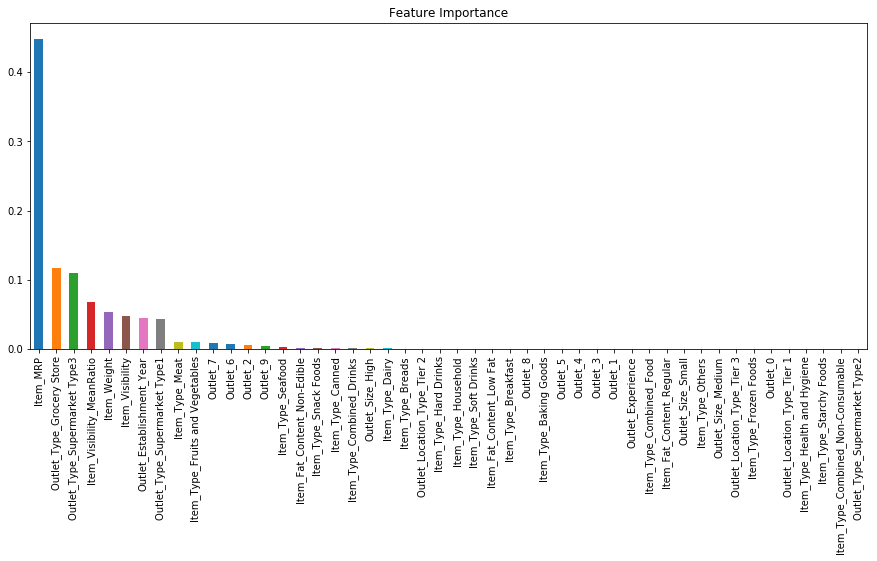

In [40]:
clf= XGBRegressor(max_depth = 3, learning_rate = 0.01, n_estimators = 500, booster = 'dart')
XGBR1 = model(clf)
XGBR1.to_csv('XGBR1.csv', index = None)

However using GridSeachCV not worked that much well on the test data.

Lastly, let's take some of the top features of XGBoost and look if performance is improved

In [56]:
X_train = X_train[['Item_MRP', 'Item_Visibility_MeanRatio', 'Item_Visibility', 'Item_Weight', 'Outlet_Type_Supermarket Type3', 'Outlet_Type_Grocery Store', 'Outlet_Establishment_Year', 'Outlet_Type_Supermarket Type1', 'Outlet_6' , 'Item_Type_Snack Foods', 'Outlet_9', 'Outlet_7', 'Outlet_8','Item_Type_Fruits and Vegetables', 'Item_Type_Seafood']]
X_test = X_test[['Item_MRP', 'Item_Visibility_MeanRatio', 'Item_Visibility', 'Item_Weight', 'Outlet_Type_Supermarket Type3', 'Outlet_Type_Grocery Store', 'Outlet_Establishment_Year', 'Outlet_Type_Supermarket Type1', 'Outlet_6' , 'Item_Type_Snack Foods', 'Outlet_9', 'Outlet_7', 'Outlet_8','Item_Type_Fruits and Vegetables', 'Item_Type_Seafood']]

RMSE : 1036.3437940398398
Mean CV_Score 1084.0887460461388


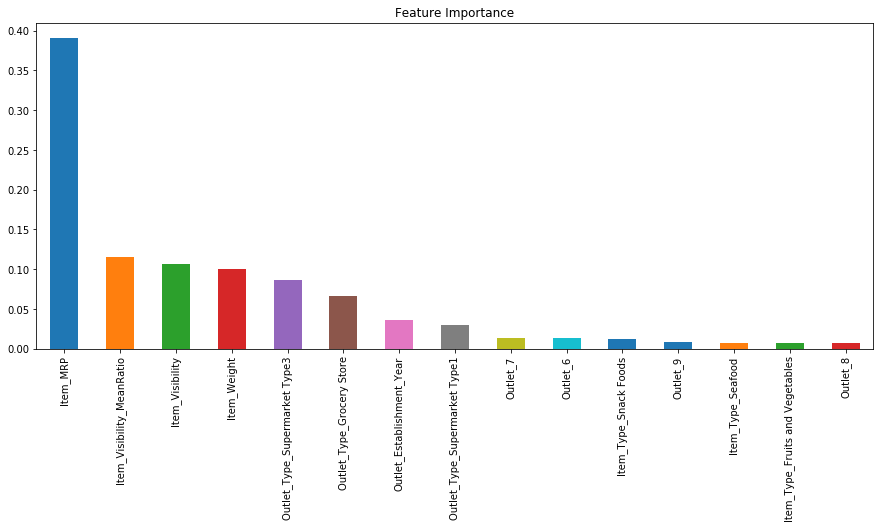

In [57]:
clf = XGBRegressor(random_state = 0)
XGBR2 = model(clf)
XGBR2.to_csv('XGBR2.csv', index = None)

Performance is slightly improved in test data.

Thus, this was all about predicting sales data. Now, we can see that feature engineering here helped us to improve our model. Further defining new feature may help us more.